In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
device = torch.device('cuda:0')

# Reading Data

In [2]:
df = pd.read_csv('../Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
Thousands of Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


# Preprocessing

In [4]:
# storing mean and variance
series_mean = df['Thousands of Passengers'].mean()
series_std = df['Thousands of Passengers'].std()

In [5]:
# Normalizing
df['Yt_true'] = df['Thousands of Passengers']
df['Yt_true'] = (df['Yt_true'] - series_mean) / series_std

In [6]:
lag = 12
for i in range(lag, 0, -1):
    df['Yt-' + str(i)] = df['Yt_true'].shift(i)

In [7]:
df.head()

,Thousands of Passengers,Yt_true,Yt-12,Yt-11,Yt-10,Yt-9,Yt-8,Yt-7,Yt-6,Yt-5,Yt-4,Yt-3,Yt-2,Yt-1
Month,,,,,,,,,,,,,,
1949-01-01,112,-1.402882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,-1.352868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.402882
1949-03-01,132,-1.236169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.402882,-1.352868
1949-04-01,129,-1.261176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.402882,-1.352868,-1.236169
1949-05-01,121,-1.327861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.402882,-1.352868,-1.236169,-1.261176


In [8]:
df.dropna(inplace=True)

In [9]:
df.head()

,Thousands of Passengers,Yt_true,Yt-12,Yt-11,Yt-10,Yt-9,Yt-8,Yt-7,Yt-6,Yt-5,Yt-4,Yt-3,Yt-2,Yt-1
Month,,,,,,,,,,,,,,
1950-01-01,115,-1.377875,-1.402882,-1.352868,-1.236169,-1.261176,-1.327861,-1.211162,-1.102798,-1.102798,-1.202826,-1.344532,-1.469568,-1.352868
1950-02-01,126,-1.286183,-1.352868,-1.236169,-1.261176,-1.327861,-1.211162,-1.102798,-1.102798,-1.202826,-1.344532,-1.469568,-1.352868,-1.377875
1950-03-01,141,-1.161148,-1.236169,-1.261176,-1.327861,-1.211162,-1.102798,-1.102798,-1.202826,-1.344532,-1.469568,-1.352868,-1.377875,-1.286183
1950-04-01,135,-1.211162,-1.261176,-1.327861,-1.211162,-1.102798,-1.102798,-1.202826,-1.344532,-1.469568,-1.352868,-1.377875,-1.286183,-1.161148
1950-05-01,125,-1.294518,-1.327861,-1.211162,-1.102798,-1.102798,-1.202826,-1.344532,-1.469568,-1.352868,-1.377875,-1.286183,-1.161148,-1.211162


In [10]:
len(df)

132

In [11]:
arr = df.values

In [12]:
npx = arr[:, 2:]
npy = arr[:, 1]

In [13]:
X = torch.from_numpy(npx).unsqueeze(2).float()
Y = torch.from_numpy(npy).float()
X = X.to(device)
Y = Y.to(device)

In [14]:
rnn_length=100

In [15]:
class EncDecWithAttn(nn.Module):
    
    def __init__(self):
        super(EncDecWithAttn, self).__init__()
        self.encoder_rnn = nn.RNN(1, rnn_length, batch_first=False, bidirectional=True)
        self.attn = nn.MultiheadAttention(2*rnn_length, 2)
        self.decoder_rnn = nn.RNN(2*rnn_length, 2*rnn_length, batch_first=False, bidirectional=False)
        self.fc = nn.Linear(2*rnn_length, 1)
        
    def forward(self, x, trace=False, ret_attn=False):
        if trace:
            print('x = ', x.shape)
        encoder_out, encoder_h = self.encoder_rnn(x)
        final_out = None
        overall_attn_weights = None
        if trace:
            print('encoder_out = ', encoder_out.shape, ' encoder_h = ', encoder_h.shape)
            print()
        encoder_out = encoder_out.permute(1, 0, 2)
        if trace:
            print('encoder_out = ', encoder_out.shape, ' encoder_h = ', encoder_h.shape)
            print()
        for i in range(x.size(1)):
            if i == 0:
                query = torch.zeros(1, x.size(0), 2*rnn_length).to(device)
                if trace:
                    print('query = ', query.shape, 'key = ', encoder_out.shape, 'value = ', encoder_out.shape)
                    print()
                attn_output, attn_weights = self.attn(query, encoder_out, encoder_out)
                overall_attn_weights = attn_weights
                if trace:
                    print('attn_output = ', attn_output.shape, 'attn_weights = ', attn_weights.shape)
                    print()
                decoder_out, decoder_hidden = self.decoder_rnn(attn_output)
                if trace:
                    print('decoder_out', decoder_out.shape, 'decoder_hidden', decoder_hidden.shape)
                    print()
                final_out = self.fc(decoder_out)
                if trace:
                    print('final_out', final_out.shape)
                    print()
                    print()
            else:
                query = decoder_hidden
                if trace:
                    print('query = ', query.shape, 'key = ', encoder_out.shape, 'value = ', encoder_out.shape)
                    print()
                attn_output, attn_weights = self.attn(query, encoder_out, encoder_out)
                overall_attn_weights = torch.cat([ overall_attn_weights, attn_weights], dim=1)
                if trace:
                    print('attn_output = ', attn_output.shape, 'attn_weights = ', attn_weights.shape)
                    print()
                decoder_out, decoder_hidden = self.decoder_rnn(attn_output)
                if trace:
                    print('decoder_out', decoder_out.shape, 'decoder_hidden', decoder_hidden.shape)
                    print()
                final_out = torch.cat([final_out, self.fc(decoder_out)], dim=0)
                if trace:
                    print('final_out', final_out.shape)
                    print()
                    print()
        final_out = final_out.permute(1, 0, 2)
        final_out = final_out.squeeze()
        if ret_attn:
            return final_out[:, -1], overall_attn_weights
        return final_out[:, -1]

In [16]:
model = EncDecWithAttn()
model = model.to(device)

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [18]:
trainX = X[:120]
trainY_true = Y[:120]
testX = X[120:]
testY_true = Y[120:]

In [19]:
BS = 32
for i in range(1000):
    optimizer.zero_grad()
    y_pred = model(trainX)
    loss = criterion(y_pred, trainY_true)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(i, loss.item())

0 0.717178225517273
100 0.1191408783197403
200 0.04171111062169075
300 0.034094106405973434
400 0.021695304661989212
500 0.016356583684682846
600 0.011413794942200184
700 0.008805429562926292
800 0.005946340970695019
900 0.004631552379578352


In [20]:
trainY_pred = model(trainX)

In [21]:
rescaled_trainY_true = (trainY_true * series_std) + series_mean
rescaled_trainY_pred = (trainY_pred * series_std) + series_mean

In [22]:
testY_pred = model(testX)

In [23]:
Y_pred = torch.cat([trainY_pred, testY_pred], dim=0)

In [24]:
len(Y_pred)

132

In [25]:
df['Yt_pred'] = Y_pred.cpu().detach().numpy()

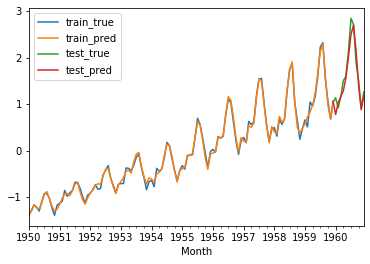

In [26]:
df['Yt_true'][:120].plot(legend=True, label='train_true')
df['Yt_pred'][:120].plot(legend=True, label='train_pred')
df['Yt_true'][119:].plot(legend=True, label='test_true')
df['Yt_pred'][119:].plot(legend=True, label='test_pred')

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(df['Yt_true'], df['Yt_pred'])
print('MSE : %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)
nrmse_mean = rmse/np.mean(df['Yt_true'])
print('NRMSE using mean: %f' % nrmse_mean)
nrmse_std = rmse/np.std(df['Yt_true'])
print('NRMSE using stdev: %f' % nrmse_std)
nrmse_range = rmse/(np.max(df['Yt_true'])- np.min(df['Yt_true']))
print('NRMSE using range: %f' % nrmse_range)
mae = mean_absolute_error(df['Yt_true'], df['Yt_pred'])
print('MAE: %f' % mae)

MSE : 0.006612
RMSE: 0.081312
NRMSE using mean: 0.698434
NRMSE using stdev: 0.084792
NRMSE using range: 0.019202
MAE: 0.057145


In [28]:
print('Train')
mse = mean_squared_error(df['Yt_true'][:120], df['Yt_pred'][:120])
print('MSE : %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)
nrmse_mean = rmse/np.mean(df['Yt_true'][:120])
print('NRMSE using mean: %f' % nrmse_mean)
nrmse_std = rmse/np.std(df['Yt_true'][:120])
print('NRMSE using stdev: %f' % nrmse_std)
nrmse_range = rmse/(np.max(df['Yt_true'][:120])- np.min(df['Yt_true'][:120]))
print('NRMSE using range: %f' % nrmse_range)

print('\n\nTest')
mse = mean_squared_error(df['Yt_true'][120:], df['Yt_pred'][120:])
print('MSE : %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)
nrmse_mean = rmse/np.mean(df['Yt_true'][120:])
print('NRMSE using mean: %f' % nrmse_mean)
nrmse_std = rmse/np.std(df['Yt_true'][120:])
print('NRMSE using stdev: %f' % nrmse_std)
nrmse_range = rmse/(np.max(df['Yt_true'][120:])- np.min(df['Yt_true'][120:]))
print('NRMSE using range: %f' % nrmse_range)

Train
MSE : 0.003897
RMSE: 0.062423
NRMSE using mean: -1.773058
NRMSE using stdev: 0.073558
NRMSE using range: 0.016829


Test
MSE : 0.033761
RMSE: 0.183743
NRMSE using mean: 0.112540
NRMSE using stdev: 0.296166
NRMSE using range: 0.095013


In [29]:
_, attn = model(X, ret_attn=True)

In [30]:
torch.sum(attn[:, -1, :], dim=0).detach().cpu().numpy()

array([ 8.329265 ,  9.087486 , 11.217855 , 16.070278 , 16.657072 ,
       11.7549095, 10.628694 , 10.524212 , 10.2717705,  9.649425 ,
        9.1056595,  8.703371 ], dtype=float32)

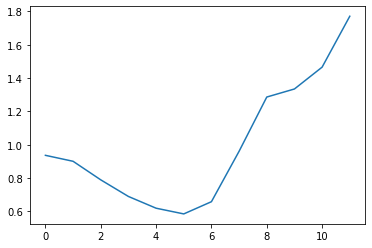

In [33]:
plt.plot(torch.sum(attn[120:, -1, :], dim=0).detach().cpu().numpy())